In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import shutil
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorboard
import os
import pandas as pd
import math
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception
import cv2

In [2]:
# In this Xception model, we are performing the following changes:
# 1. The traininng data used will be from the folder train_70% which is unaugmented
# 2. since the training data is also not pre processed or subjected to any hair removal, we will apply resnet
# pre process function in the image data generator function.
# To balance the skewed classes while training, we will use the class weights.
# The validation data and test data will be the initial 15% data subjected to resnet pre processing
# We will also apply random augmentations in the image data generator

In [3]:
batch_size = 32
img_height = 128
img_width = 128

In [4]:
# inhibit graphics card runs out of memory
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
dataset = 'Data/Processed_Data/train'
dataset_path = os.listdir(dataset)

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

['train_ak_aug', 'train_bcc_aug', 'train_bkl_aug', 'train_df_aug', 'train_mel_aug', 'train_nv_aug', 'train_scc_aug', 'train_vasc_aug']
Types of classes labels found:  8


In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# create a directory to save the files
create_dir("models")

In [7]:
# load the augmented data from the local data directory:

train_dir = "Data/train_70%"
test_dir = "Data/Processed_Data/test"
valid_dir = "Data/Processed_Data/valid"

datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2,rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True, vertical_flip=True, data_format="channels_last",
                                        dtype=tf.float32, preprocessing_function=preprocess_input)
                                        # The imported data will be normalized here.


test_datagen = ImageDataGenerator(data_format="channels_last", dtype=tf.float32,
                                    preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    seed=123) # set as training data

validation_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    seed=123) # set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    seed=123,) # set as testing data

Found 17728 images belonging to 8 classes.
Found 3796 images belonging to 8 classes.
Found 3799 images belonging to 8 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\GHAYAAS\anaconda3\envs\gpuEnv\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


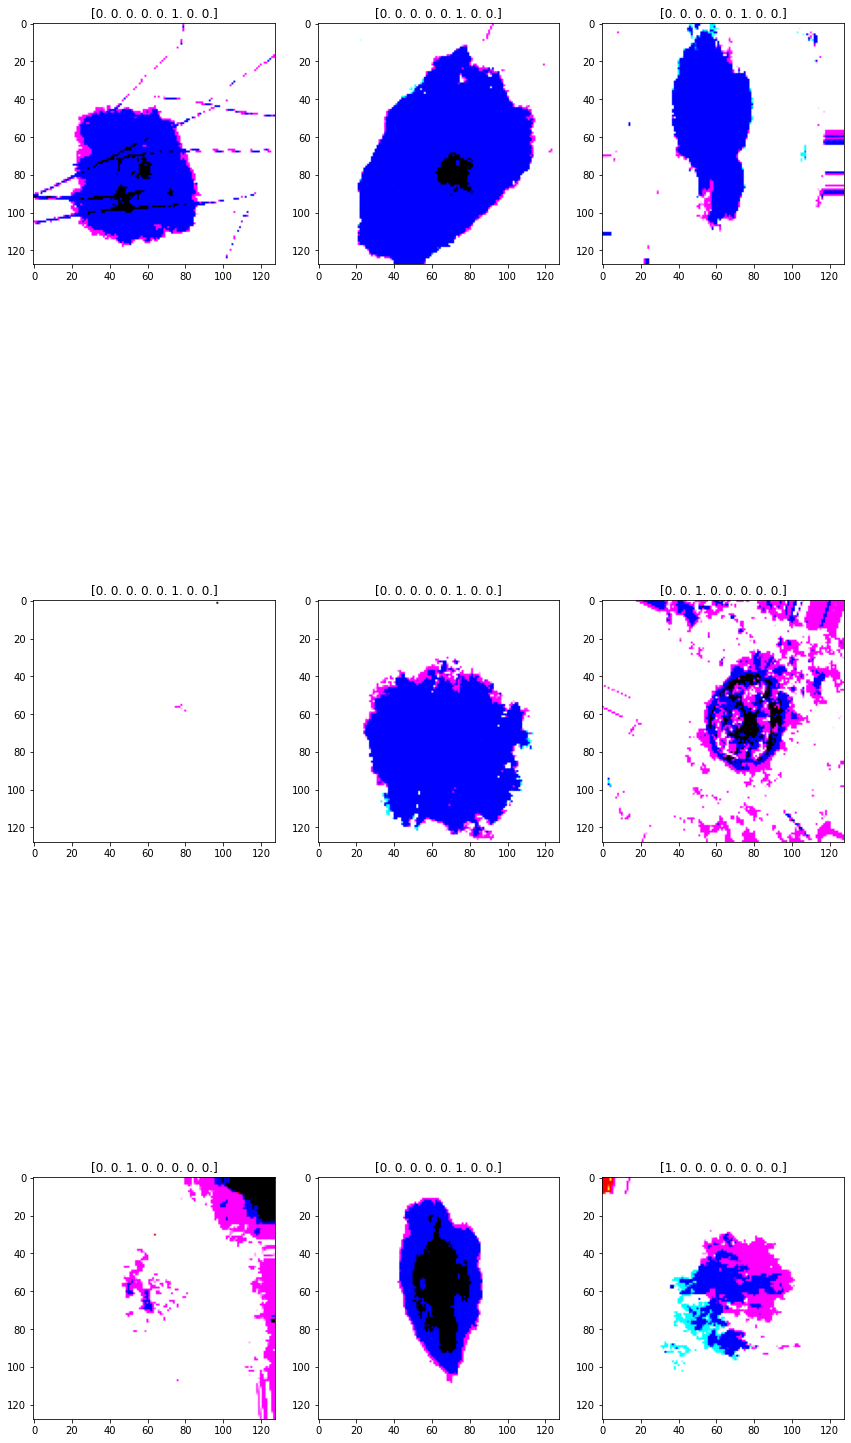

In [8]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,27))

for i, a in enumerate(ax.flat):
    img, label = train_generator.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

In [9]:
# Define some model parameters
input_shape = (img_height, img_width, 3)
training_shape = (img_height,img_width,3)
num_classes = 8

optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.0000001)
early_stopping_monitor = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath="Xception_weights_CW_P.h5", verbose=0, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode ='auto', save_freq='epoch')

In [10]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), weights))
#weights = np.array([ 3.65592784,  0.95278076,  1.20702859, 13.23227612,  0.70028633, 0.2459258 ,  5.03728693, 12.48679577])

In [11]:
class_weights

{0: 3.6567656765676566,
 1: 0.9527085124677558,
 2: 1.2069716775599129,
 3: 13.269461077844312,
 4: 0.7001579778830964,
 5: 0.2458943630714603,
 6: 5.047835990888383,
 7: 12.519774011299434}

In [12]:
# Defining an Xception model

base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)

XCeptionmodel = base_model.output
XCeptionmodel = Flatten()(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionmodel = Dense(128, activation='relu')(XCeptionmodel)
XCeptionmodel = Dropout(0.2)(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionoutput = Dense(num_classes, activation = 'softmax')(XCeptionmodel)
XCeptionmodel = Model(inputs=base_model.input, outputs=XCeptionoutput)

model = XCeptionmodel

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [13]:
history = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch=train_generator.samples//batch_size,
    validation_data = validation_generator,
    validation_steps=validation_generator.samples//batch_size,
    callbacks=[learning_rate_reduction,early_stopping_monitor, checkpointer], class_weight=class_weights)

Epoch 1/100
554/554 [==============================] - 336s 607ms/step - loss: 2.0900 - accuracy: 0.2541 - val_loss: 2.0117 - val_accuracy: 0.2879
Epoch 2/100
554/554 [==============================] - 327s 591ms/step - loss: 1.8020 - accuracy: 0.3325 - val_loss: 1.8822 - val_accuracy: 0.2918
Epoch 3/100
554/554 [==============================] - 317s 572ms/step - loss: 1.6308 - accuracy: 0.3890 - val_loss: 1.5283 - val_accuracy: 0.4253
Epoch 4/100
554/554 [==============================] - 325s 587ms/step - loss: 1.5835 - accuracy: 0.4204 - val_loss: 1.5774 - val_accuracy: 0.4010
Epoch 5/100
554/554 [==============================] - 311s 561ms/step - loss: 1.6099 - accuracy: 0.3993 - val_loss: 1.6527 - val_accuracy: 0.4108
Epoch 6/100
554/554 [==============================] - 314s 567ms/step - loss: 1.5117 - accuracy: 0.4552 - val_loss: 2.0515 - val_accuracy: 0.3583
Epoch 7/100
554/554 [==============================] - 325s 587ms/step - loss: 1.4823 - accuracy: 0.4490 - val_loss: 1

In [ ]:
#model.save("models/model_Xception_CW_P.h5")

In [8]:
model = tf.keras.models.load_model("models/model_Xception_CW_P.h5")

In [9]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['ak', 'bcc', 'bkl', 'df', 'mel','nv', 'scc', 'vasc']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[  4  10  28   1  27  57   1   2]
 [ 14  49  70   2  94 248  11  10]
 [ 11  59  63   3  66 178   8   6]
 [  3   4   4   1   7  17   0   0]
 [ 21  87  80  16 125 315  24  10]
 [ 72 212 277  18 377 918  38  19]
 [  3  11  11   4  18  42   5   0]
 [  4   2   6   0   5  20   0   1]]
Classification Report
              precision    recall  f1-score   support

          ak       0.03      0.03      0.03       130
         bcc       0.11      0.10      0.11       498
         bkl       0.12      0.16      0.14       394
          df       0.02      0.03      0.02        36
         mel       0.17      0.18      0.18       678
          nv       0.51      0.48      0.49      1931
         scc       0.06      0.05      0.06        94
        vasc       0.02      0.03      0.02        38

    accuracy                           0.31      3799
   macro avg       0.13      0.13      0.13      3799
weig

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_generator.classes, y_pred))

0.30692287444064226


In [11]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(test_generator.classes, y_pred))

0.1320141833750592
